<div style="border: 5px solid purple; padding: 10px; margin: 5px">
<b> Svetlana's comment  </b>
    

Hi Michael, my name is Svetlana (https://hub.tripleten.com/u/6dee602c).


Thank you for submitting such an excellent report! It is well-organized, following a logical structure: what was done, the challenges you faced, the decisions you made, and final results. This makes it easy to follow. You don't need to change anything, because it's great! 
    
Good luck! 

</div>

# Introduction

## Description

The telecom operator Interconnect would like to be able to forecast the churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of the clientele's personal data, including information about their plans and contracts.

### Business Problem Statement

The company wants to forecast which users are planning to leave.

### Business Value

To ensure loyalty, those who are going to leave will be offered promotional codes and special plan options.

## Procedure

- Individual datasets
  - Import datasets
  - Data preprocessing
- Combined datasets
  - Combine datasets
  - Data preprocessing
- EDA
- Modeling
  - Preparation
  - Train Models
  - Model Analysis
- Conclusion

# Imports

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

import lightgbm as lgb
import xgboost as xgb

# Individual datasets

## Import Datasets

### Data Description

The data consists of files obtained from different sources:

- contract.csv — contract information
- personal.csv — the client's personal data

- internet.csv — information about Internet services

- phone.csv — information about telephone services

In each file, the column customerID contains a unique code assigned to each client.

In [2]:
# Import data

contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Data Preprocessing

### Function Definitions

In [3]:
# a function to perform basic EDA for all datasets
def get_info(df):
    print(df.head(5))
    print()
    print('')
    print(df.info())
    print()
    print()
    print(df.describe())
    print()
    print('Null entries:')
    print(df.isna().sum())
    print()
    print('Number of duplicates:')
    print(df.duplicated().sum())

### Contract

Contract

Contract information is stored in 'contract.csv'.

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

In [4]:
get_info(contract)

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null C

Observation on Contract:
- Inconsistent branding is used in column names.
  - customerID should be CustomerID
- BeginDate is of type object but is a date
- EndDate is of type object but is a date
  - EndDate contains "No", non time values when the contract has not ended
- Type is of type object but is categorical
- PaperlessBilling is of type object but is categorical
- PaymentMethod is of type object but is categorical
- TotalCharges is of type object but is a float

#### Rename Columns

In [5]:
# Rename customerID to be brand consistent:

contract.rename(columns={'customerID': 'CustomerID'}, inplace=True)

#### Data type conversions

In [6]:
# convert objects to categories

contract['Type'] = contract['Type'].astype('category')
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype('category')
contract['PaymentMethod'] = contract['PaymentMethod'].astype('category')

In [7]:
# Convert date columns to datetime

contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

In [8]:
# Convert 'TotalCharges' to float64, coercing errors to NaN
print('Empty entries in TotalCharges:')
print((contract['TotalCharges']==' ').sum())

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Empty entries in TotalCharges:
11


11 empty entries have been identified in TotalCharges. These will be addressed later.

#### Feature Engineering

Feature Engineering:

- An additional feature can be added by calculating the length of the contract. If the contract has not ended, the date the data was pulled will be used.
- Year and month can also be extracted from the start date of the contract.

In [9]:
pull_date = pd.to_datetime('2020-02-01')

# Create end_time column: use pull_date where EndDate is NaT, otherwise use EndDate
contract['end_time'] = contract['EndDate'].fillna(pull_date)

# Calculate contract length
contract['ContractLength'] = contract['end_time'] - contract['BeginDate']

# Clean up the temporary column
contract.drop('end_time', axis=1, inplace=True)

In [10]:
# Add a column for Begin Year

contract['Year'] = contract['BeginDate'].dt.year
contract['Month'] = contract['BeginDate'].dt.month

### Personal

Personal

personal.csv — the client's personal data

Personal information about the customer, including the gender, partner status, and dependent status.

In [11]:
get_info(personal)

   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

Null e

Observations on Personal
- Inconsistent branding is used in column names.
  - customerID should be CustomerID
  - gender should be Gender
- Inconsistent style is applied in the Personal data:
  - Gender uses Female / Male
  - SeniorCitizen uses 0 / 1
  - Partner uses No / Yes
  - Dependents uses No / Yes
- Gender is of type object but is a category
- SeniorCitizen is of type int but is a category
- Partner is of type object but is a category
- Dependents of of type object but is a category 

#### Rename Columns

In [12]:
personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'}, inplace=True)

#### Data Type Conversions

In [13]:
personal['Gender'] = personal['Gender'].astype('category')
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}).astype('category')
personal['Partner'] = personal['Partner'].astype('category')
personal['Dependents'] = personal['Dependents'].astype('category')

#### Feature Engineering

### Internet

Internet

Information about Internet services is contained in 'internet.csv'.

The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some other services the company provides include:
- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
- A dedicated technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV) and a movie directory (StreamingMovies)

In [14]:
get_info(internet)

   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService 

Observations on Internet:
- Inconsistent branding is used in column names.
  - customerID should be CustomerID 
- InternetService is of type object but is a category
- OnlineSecurity is of type object but is a category
- OnlineBackup is of type object but is a category
- DeviceProtection is of type object but is a category
- TechSupport is of type object but is a category
- StreamingTV is of type object but is a category
- StreamingMovies is of type object but is a category

#### Rename Columns

In [15]:
internet.rename(columns={'customerID': 'CustomerID'}, inplace=True)

#### Data Type Conversions

In [16]:
col_list = ['InternetService',
            'OnlineSecurity',
            'OnlineBackup',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV', 
            'StreamingMovies']

for item in col_list:
    internet[item] = internet[item].astype('category')

#### Feature Engineering

Feature Engineering:

An additional feature can be created using the number of add on services a customer purchases.

In [17]:
# Add feature:
# An additional feature can be created using the number of add on services a customer purchases:

add_services = ['DeviceProtection', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']

internet['AdditionalServices'] = (internet[add_services] == "Yes").sum(axis=1)

### Phone

Phone

phone.csv — information about telephone services

Landline communication. The telephone can be connected to several lines simultaneously.

In [18]:
get_info(phone)

   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


        customerID MultipleLines
count         6361          6361
unique        6361             2
top     8550-XSXUQ            No
freq             1          3390

Null entries:
customerID       0
MultipleLines    0
dtype: int64

Number of duplicates:
0


Observations on Phone:
- Inconsistent branding is used in column names.
  - customerID should be CustomerID
- MultipleLines uses No/Yes values and can be encoeded to 0/1

#### Rename Columns

In [19]:
phone.rename(columns={'customerID': 'CustomerID'}, inplace=True)

#### Data Type Conversions

In [20]:
phone['MultipleLines'] = phone['MultipleLines'].astype('category')

#### Feature Engineering

## Summary

- All datasets have been imported.
- Corections have been made to column names and datatypes. 
- Additional features have been added.

# Combine Datasets

All datasets can be combined using the unique identifier, CustomerID.

## Confirming Compatability

In [21]:
# verify all customer IDs are unique:
print('Duplicate customer IDs:')
print(contract['CustomerID'].duplicated().sum(), 
      personal['CustomerID'].duplicated().sum(), 
      internet['CustomerID'].duplicated().sum(), 
      phone['CustomerID'].duplicated().sum())

Duplicate customer IDs:
0 0 0 0


In [22]:
def check_compatability(df0, df1):
    print()
    # Check how many customers are in both datasets
    print("Customers in both:", 
          len(set(df0['CustomerID']) & set(df1['CustomerID'])))
    
    # Check if all customers are in contract
    print("All customers in contract:", 
          df1['CustomerID'].isin(df0['CustomerID']).all())

In [23]:
check_compatability(contract, personal)
check_compatability(contract, internet)
check_compatability(contract, phone)


Customers in both: 7043
All customers in contract: True

Customers in both: 5517
All customers in contract: True

Customers in both: 6361
All customers in contract: True


Merging Compatibility:
- All Customer ID numbers are unique.
- Customer and personal contain the same customer IDs.
- All internet users are listed in the Customer dataset; however, not all customers are listed as internet users. These customers only use phone services.
- All phone users are listed in the Customer dataset; however, not all customers are listed in phone users. These customers only use internet services.

There are no duplicate customer ID numbers, and all customer ID numbers are represented in the contract dataset. Since not all members use all services, there will be some missing data after joining.

## Merge Datasets

In [24]:
data = personal.merge(contract, how='outer', on='CustomerID')
data = data.merge(internet, how='outer', on='CustomerID')
data = data.merge(phone, how='outer', on='CustomerID')

## Data Preprocessing

In [25]:
get_info(data)

   CustomerID  Gender SeniorCitizen Partner Dependents  BeginDate    EndDate  \
0  7590-VHVEG  Female            No     Yes         No 2020-01-01        NaT   
1  5575-GNVDE    Male            No      No         No 2017-04-01        NaT   
2  3668-QPYBK    Male            No      No         No 2019-10-01 2019-12-01   
3  7795-CFOCW    Male            No      No         No 2016-05-01        NaT   
4  9237-HQITU  Female            No      No         No 2019-09-01 2019-11-01   

             Type PaperlessBilling              PaymentMethod  ...  Month  \
0  Month-to-month              Yes           Electronic check  ...      1   
1        One year               No               Mailed check  ...      4   
2  Month-to-month              Yes               Mailed check  ...     10   
3        One year               No  Bank transfer (automatic)  ...      5   
4  Month-to-month              Yes           Electronic check  ...      9   

   InternetService OnlineSecurity  OnlineBackup  DeviceP

### Missing Values

In [26]:
display(data[data['TotalCharges'].isnull()])

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,Month,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,AdditionalServices,MultipleLines
488,4472-LVYGI,Female,No,Yes,Yes,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),...,2,DSL,Yes,No,Yes,Yes,Yes,No,4.0,NaN
753,3115-CZMZD,Male,No,No,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,DSL,Yes,Yes,Yes,No,Yes,Yes,5.0,No
1082,4367-NUYAO,Male,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,Female,No,Yes,Yes,2020-02-01,NaT,Two year,No,Credit card (automatic),...,2,DSL,Yes,Yes,Yes,Yes,Yes,No,5.0,NaN
3331,7644-OMVMY,Male,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,Male,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,Female,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,Male,No,Yes,Yes,2020-02-01,NaT,One year,Yes,Mailed check,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,Female,No,Yes,Yes,2020-02-01,NaT,Two year,No,Mailed check,...,2,DSL,No,Yes,Yes,Yes,Yes,No,4.0,Yes


TotalCharges contains eleven missing values. In all cases, the account is brand new. The missing values can be replaced with 0.

In [27]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

The following missing values are a result of members not using the service. They can be replaced with "No" to remain consistent with branding.
- InternetService
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- MultipleLines

Additional services is numeric and will be filled with 0.

In [28]:
print(data['InternetService'].cat.categories)

Index(['DSL', 'Fiber optic'], dtype='object')


In [29]:
null_list = ['InternetService', 
            'OnlineSecurity',
            'DeviceProtection',
            'TechSupport',
            'StreamingTV',
            'StreamingMovies',
            'MultipleLines',
            'OnlineBackup']

# Add "No" to the categories for InternetService
data['InternetService'] = data['InternetService'].cat.add_categories("No")

# Fill with No
for item in null_list:
    data[item] = data[item].fillna("No")

In [30]:
data['AdditionalServices'] = data['AdditionalServices'].fillna(0)

In [31]:
print(data.isna().sum())

CustomerID               0
Gender                   0
SeniorCitizen            0
Partner                  0
Dependents               0
BeginDate                0
EndDate               5174
Type                     0
PaperlessBilling         0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
ContractLength           0
Year                     0
Month                    0
InternetService          0
OnlineSecurity           0
OnlineBackup             0
DeviceProtection         0
TechSupport              0
StreamingTV              0
StreamingMovies          0
AdditionalServices       0
MultipleLines            0
dtype: int64


EndDate is missing 5174 entries. These are contracts that have not ended. A new feature will be added, churn, which will represent if a customer has left or not.

### Additional Features

In [32]:
data['Churn'] = data['EndDate'].notna()

In [33]:
print(data[['EndDate', 'Churn']].head(5))

     EndDate  Churn
0        NaT  False
1        NaT  False
2 2019-12-01   True
3        NaT  False
4 2019-11-01   True


# EDA

## Function Definitions

In [34]:
# plot numerical data

def plot_hist_bar(df, col):
    title=col
    print()
    print(title)
    
    # Plot histograms of the columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(data=df, x=col, bins=30, ax=axes[0], kde=True)
    axes[0].set_title(title)
    
    sns.boxplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(title)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
# plot categorical data

def plot_bar_count(df, col):
    title=col
    print()
    print(title)
    
    # Plot histograms of the columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(data=df, x=col, bins=30, ax=axes[0], kde=True)
    axes[0].set_title(title)
    
    sns.countplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(title)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    get_balance(df, col)

In [36]:
# Check for imbalance in categorical data
def get_balance(df, col):
    print()
    print(f'{col} value balance:')
    total_count = len(df[col])
    col_list = df[col].unique()

    for item in col_list:
        print(f'{(df[col]==item).sum()/total_count*100:.2f}% - {item}')

In [37]:
def plot_line(df, colx, coly, title):
    sns.lineplot(x=colx, y=coly, data=df)
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.title(title)
    plt.show()

In [38]:
def plot_compare(df, col0, col1):
    title=""
    print()
    print(title)
    
    # Plot histograms of the columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(data=df, x=col1, ax=axes[0], hue=col0, kde=True, alpha=0.7, bins=30)
    axes[0].set_title(title)
    
    sns.boxplot(data=df, x=col0, y=col1, ax=axes[1])
    axes[1].set_title(title)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [39]:
def plot_cat_compare(df, col, comp):
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title('Distribution by Churn Status')
    plt.xticks(rotation=45)
    plt.show()

In [40]:
# Creating a fuction for histogram visualisation
def plot_hist(df, col, hue, x_title):
    sns.histplot(data=df, x=col, hue=hue, kde=True, multiple="stack")
    plt.show()

## Demographics

### Gender


Gender


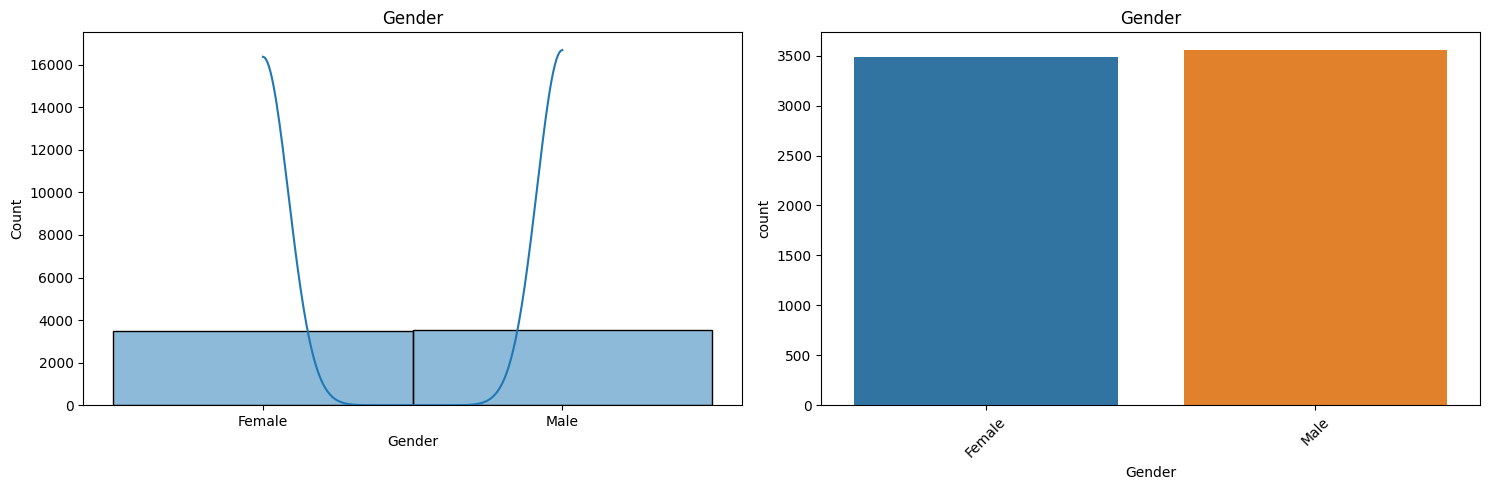


Gender value balance:
49.52% - Female
50.48% - Male


In [41]:
plot_bar_count(personal, 'Gender')

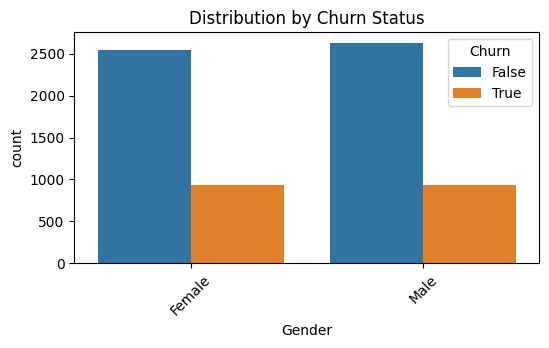

In [42]:
plot_cat_compare(data, 'Gender', 'Churn')

### Senior Citizen


SeniorCitizen


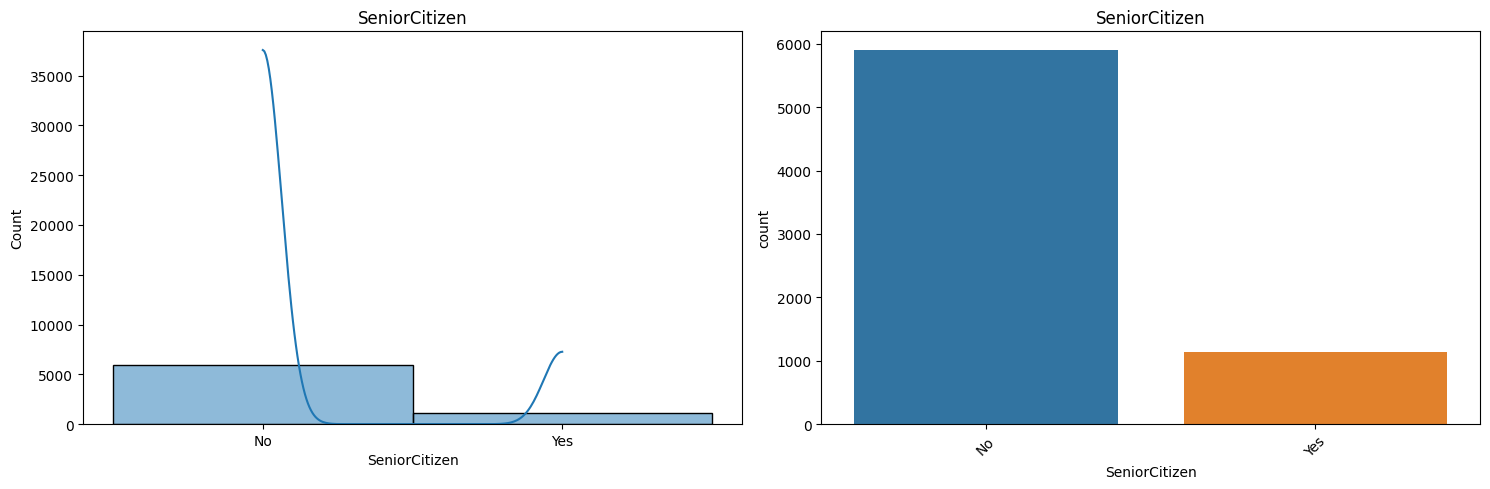


SeniorCitizen value balance:
83.79% - No
16.21% - Yes


In [43]:
plot_bar_count(personal, 'SeniorCitizen')

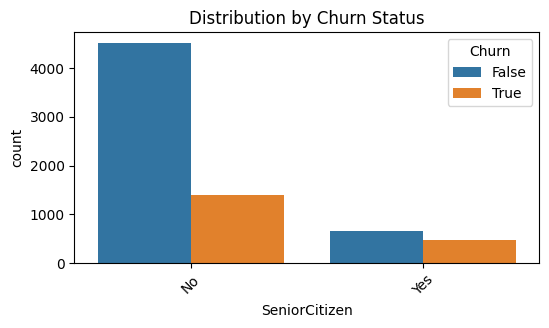

In [44]:
plot_cat_compare(data, 'SeniorCitizen', 'Churn')

### Partner


Partner


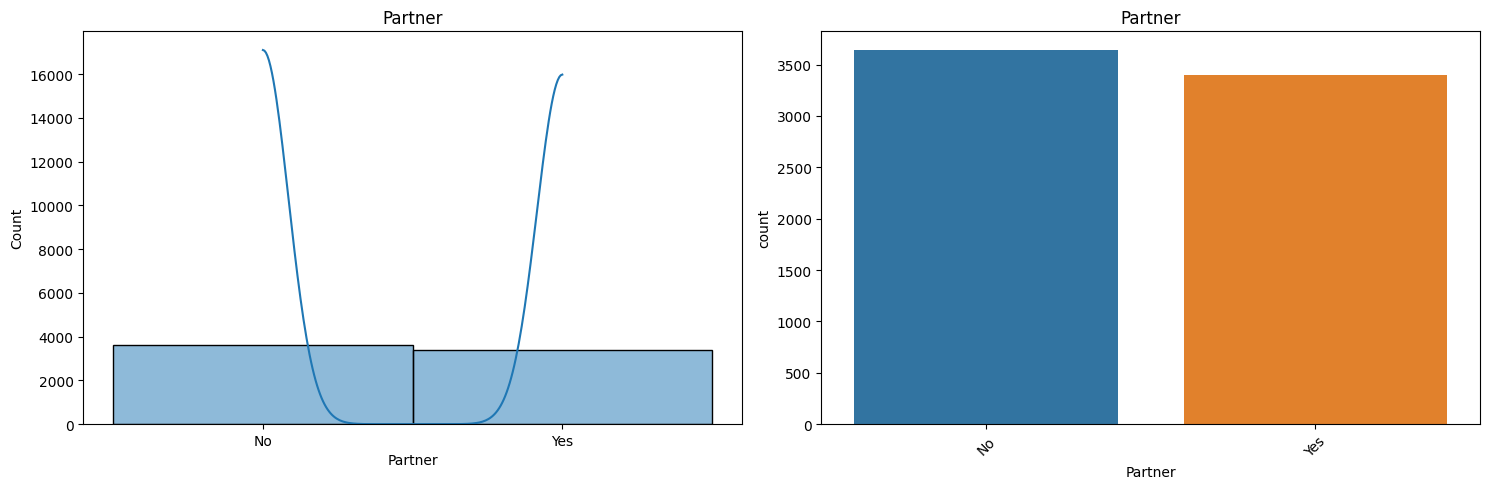


Partner value balance:
48.30% - Yes
51.70% - No


In [45]:
plot_bar_count(personal, 'Partner')

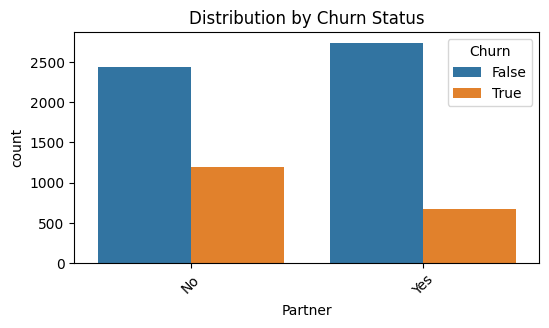

In [46]:
plot_cat_compare(data, 'Partner', 'Churn')

### Dependents


Dependents


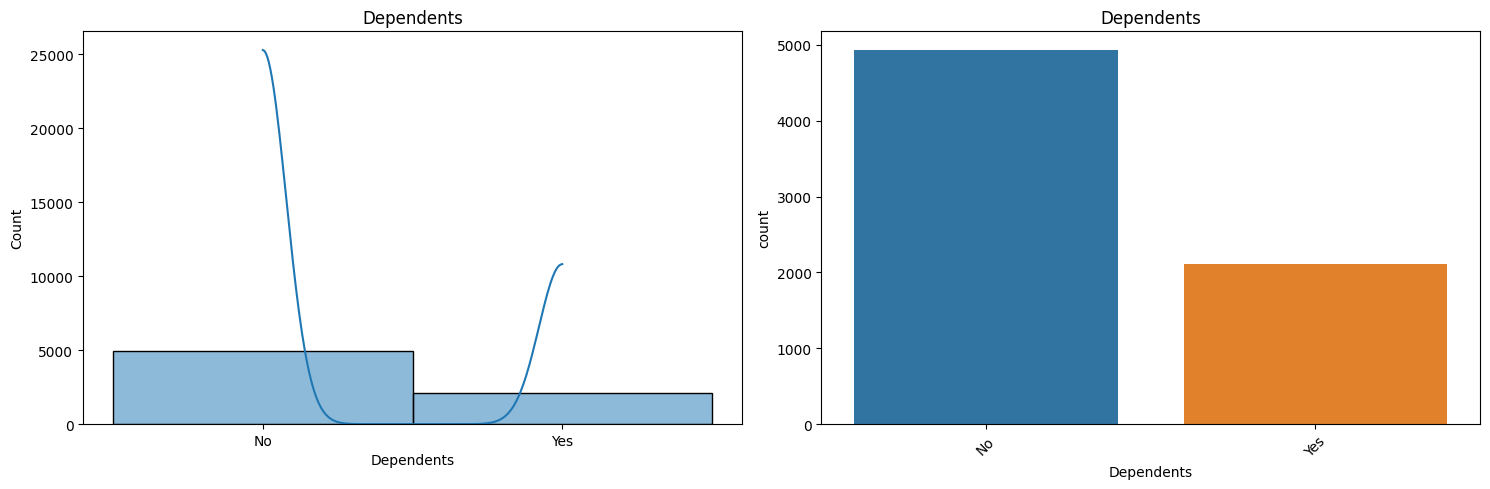


Dependents value balance:
70.04% - No
29.96% - Yes


In [47]:
plot_bar_count(personal, 'Dependents')

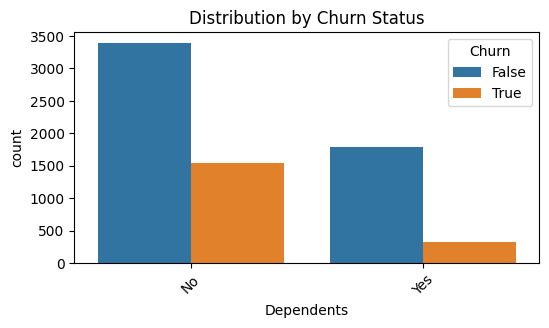

In [48]:
plot_cat_compare(data, 'Dependents', 'Churn')

## Contract

### Contract Date

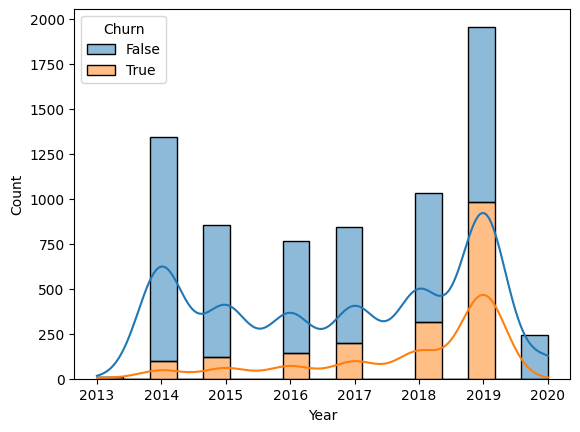

In [49]:
plot_hist(data, 'Year', 'Churn', 'Begin Year')

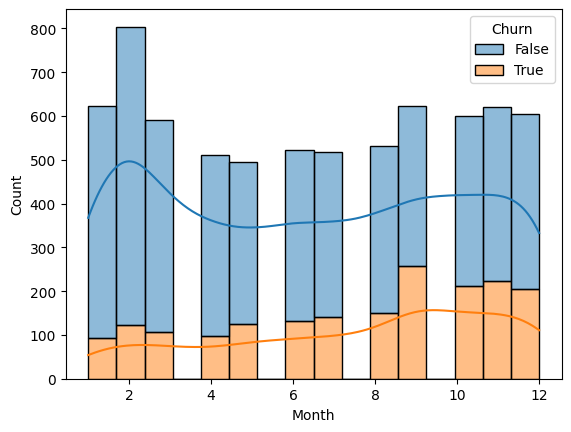

In [50]:
plot_hist(data, 'Month', 'Churn', 'Begin Year')

### Contract Type

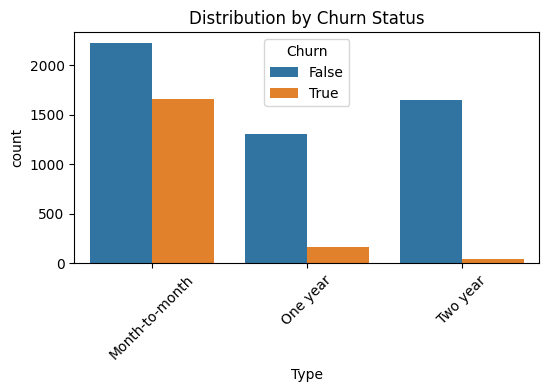

In [51]:
plot_cat_compare(data, 'Type', 'Churn')

### Billing


PaperlessBilling


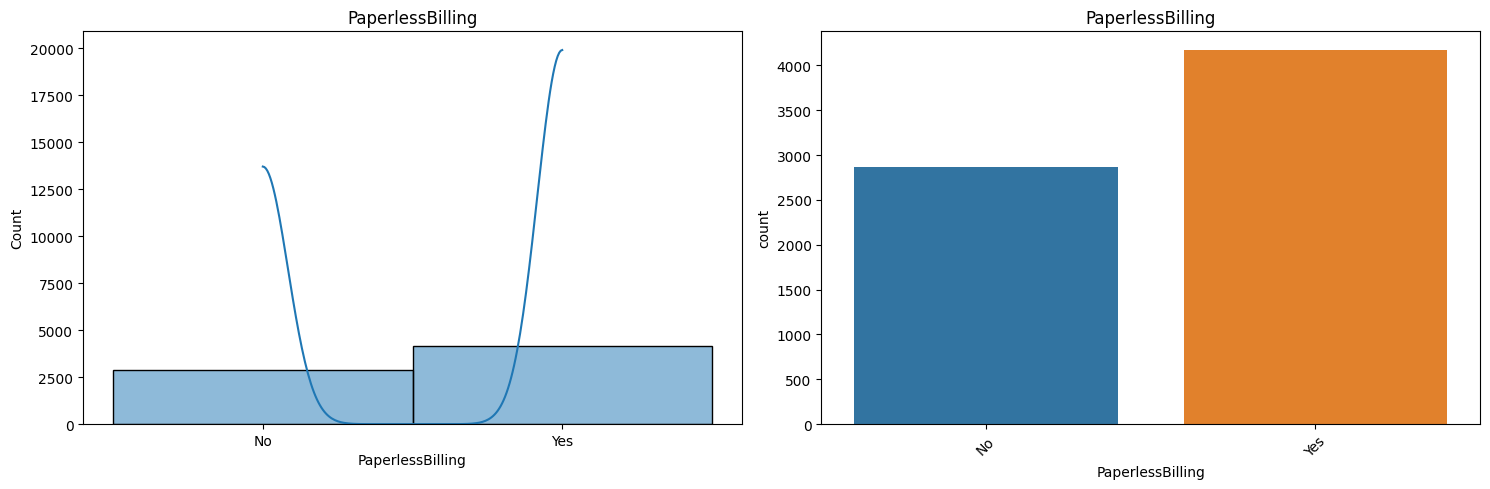


PaperlessBilling value balance:
59.22% - Yes
40.78% - No


In [52]:
plot_bar_count(contract, 'PaperlessBilling')

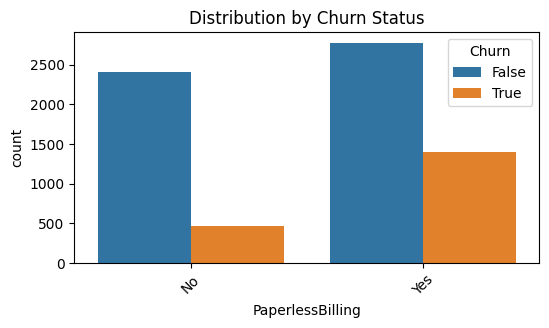

In [53]:
plot_cat_compare(data, 'PaperlessBilling', 'Churn')

### Payment Method


PaymentMethod


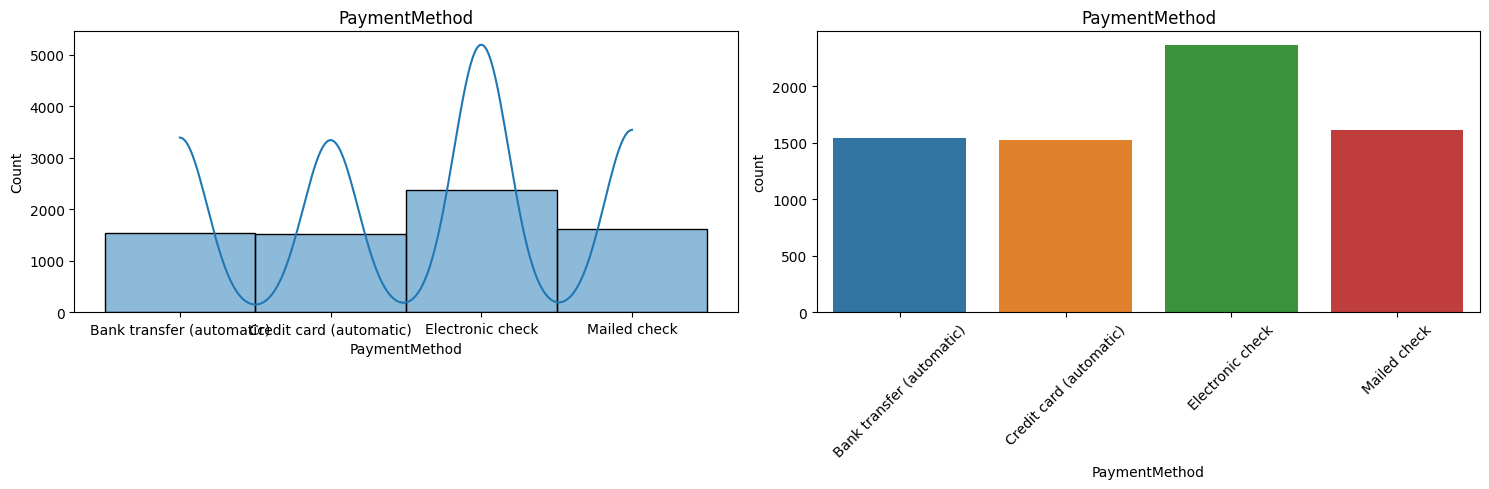


PaymentMethod value balance:
33.58% - Electronic check
22.89% - Mailed check
21.92% - Bank transfer (automatic)
21.61% - Credit card (automatic)


In [54]:
plot_bar_count(contract, 'PaymentMethod')

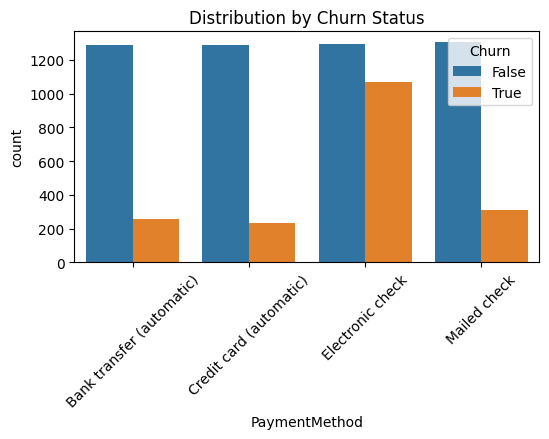

In [55]:
plot_cat_compare(data, 'PaymentMethod', 'Churn')

### Monthly Charges


MonthlyCharges


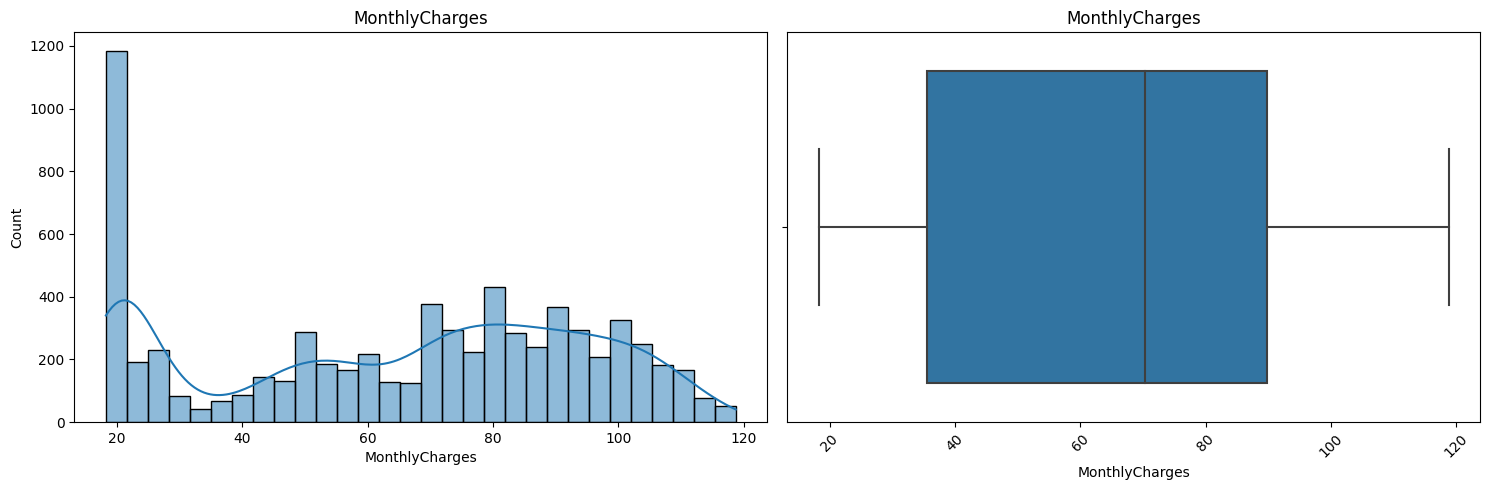

In [56]:
plot_hist_bar(contract, 'MonthlyCharges')

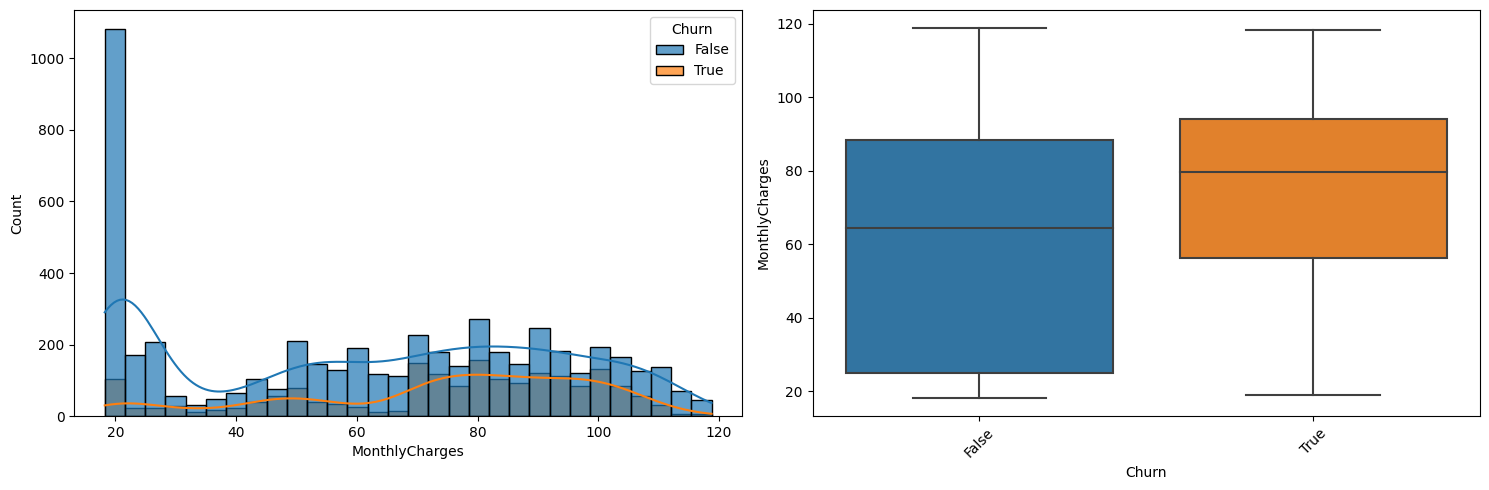

In [57]:
plot_compare(data, 'Churn', 'MonthlyCharges')

Members who have left have higher monthly charges.

### Total Charges


TotalCharges


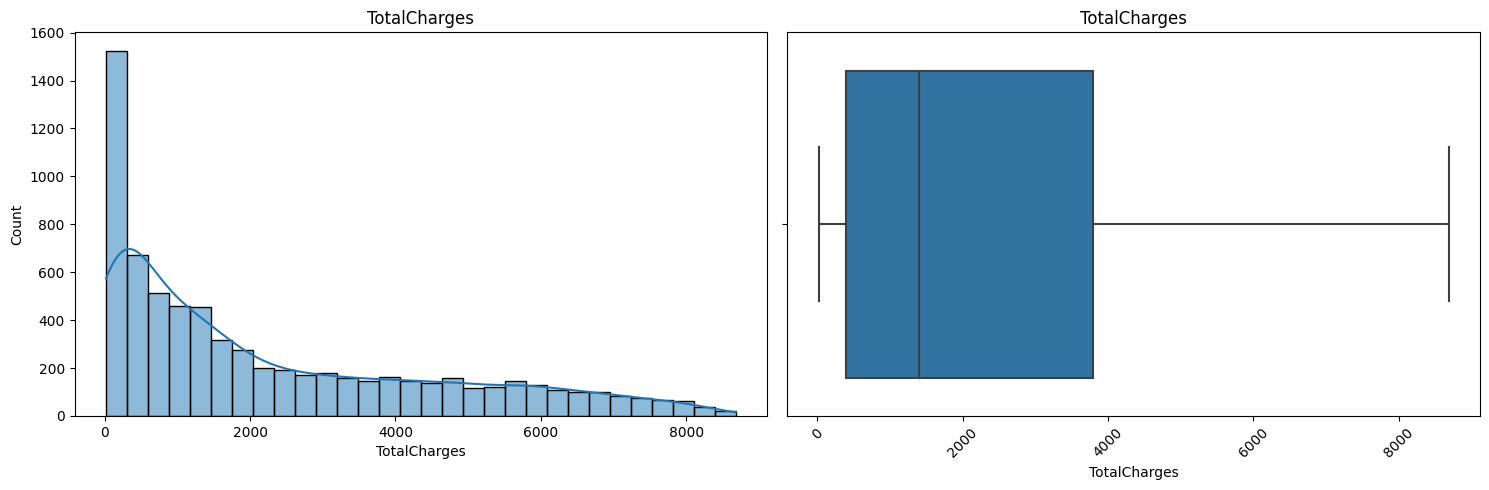

In [58]:
plot_hist_bar(contract, 'TotalCharges')

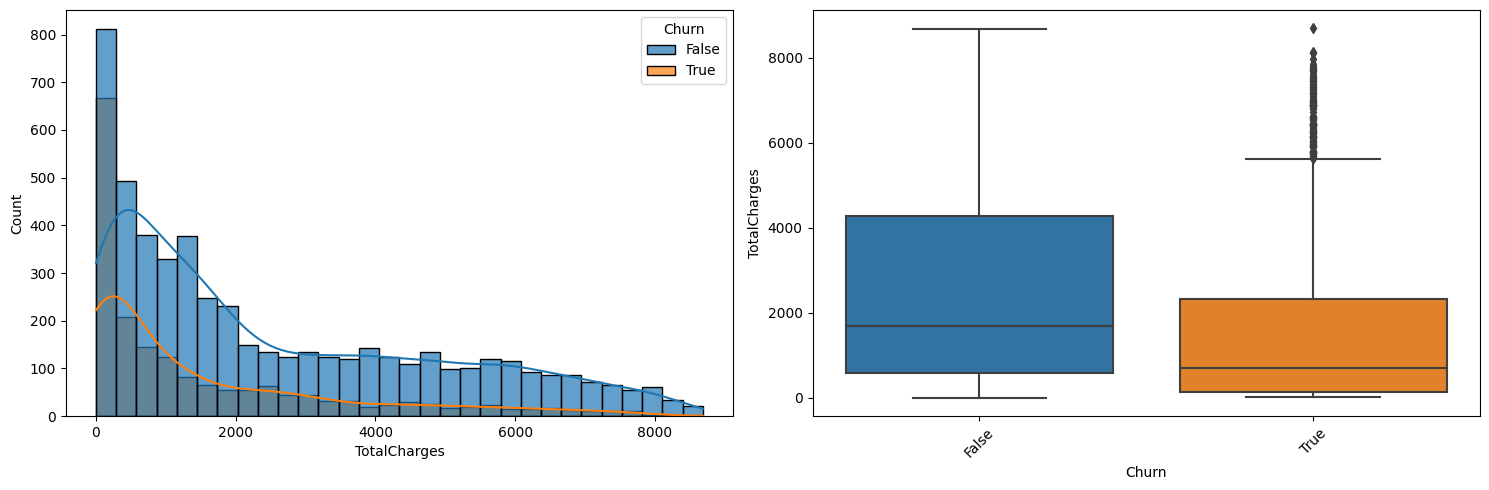

In [59]:
plot_compare(data, 'Churn', 'TotalCharges')

Members who have left have lower total charges, likely due to the length of their contract.

## Services

### Phone

#### Multiple Lines


MultipleLines


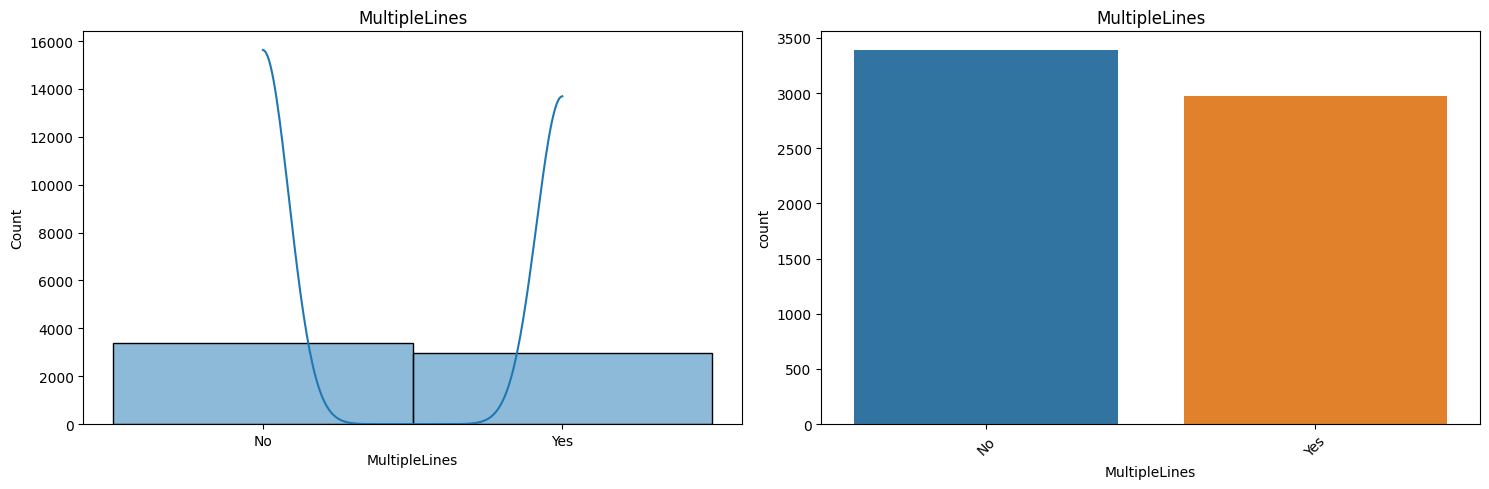


MultipleLines value balance:
53.29% - No
46.71% - Yes


In [60]:
plot_bar_count(phone, 'MultipleLines')

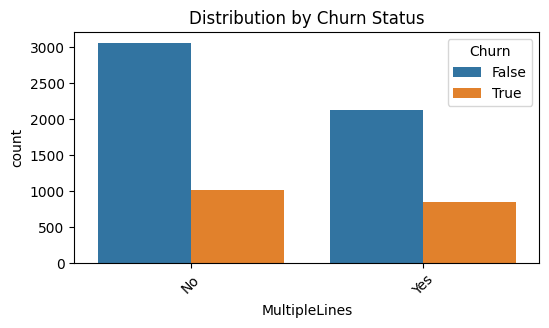

In [61]:
plot_cat_compare(data, 'MultipleLines', 'Churn')

### Internet

#### Internet Service Type


InternetService


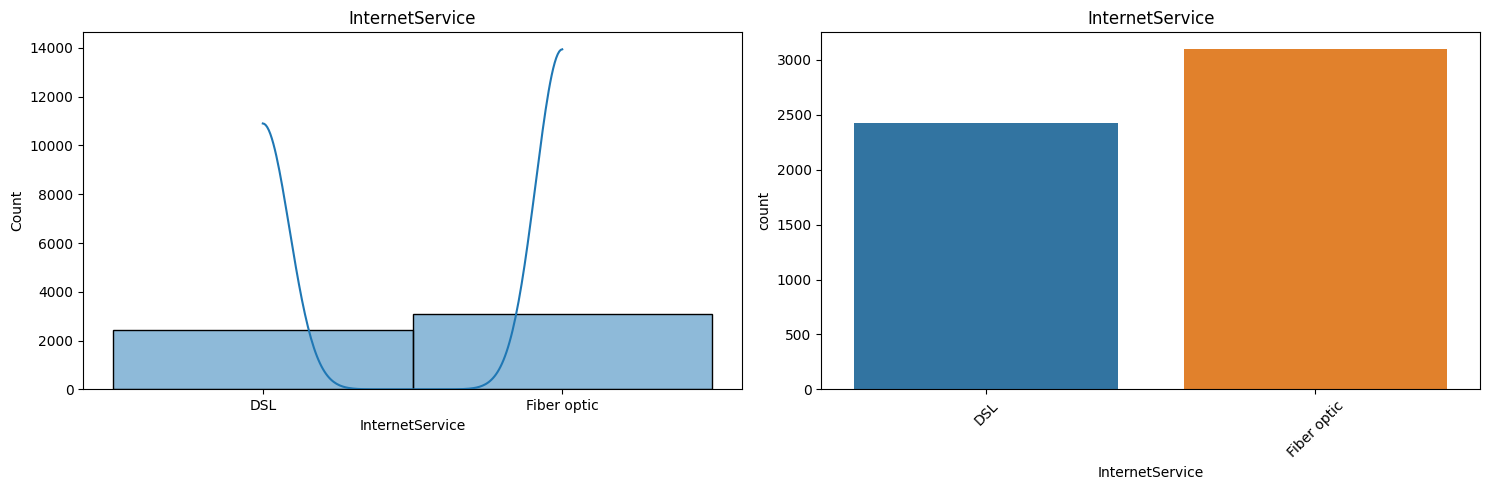


InternetService value balance:
43.88% - DSL
56.12% - Fiber optic


In [62]:
plot_bar_count(internet, 'InternetService')

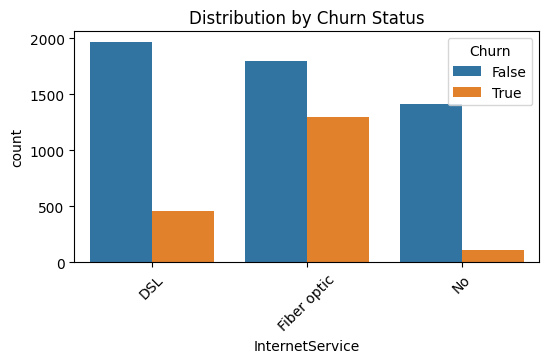

In [63]:
plot_cat_compare(data, 'InternetService', 'Churn')

Members with fiber optic internet leave at a noticeably higher rate.

#### Additional Services


AdditionalServices


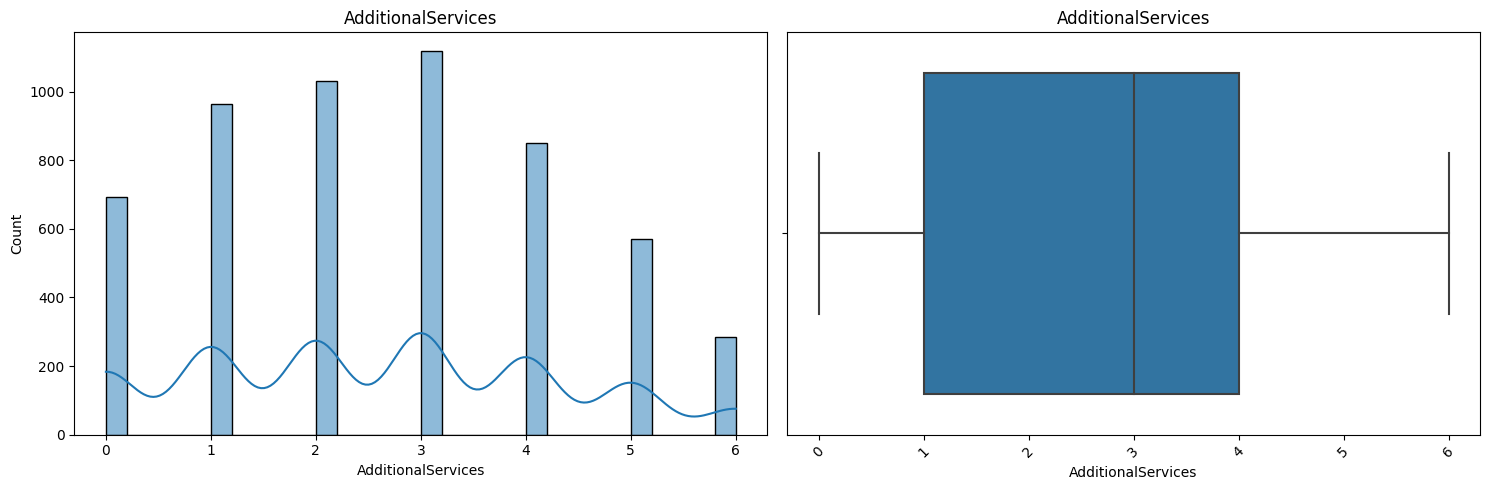

In [64]:
plot_hist_bar(internet, 'AdditionalServices')

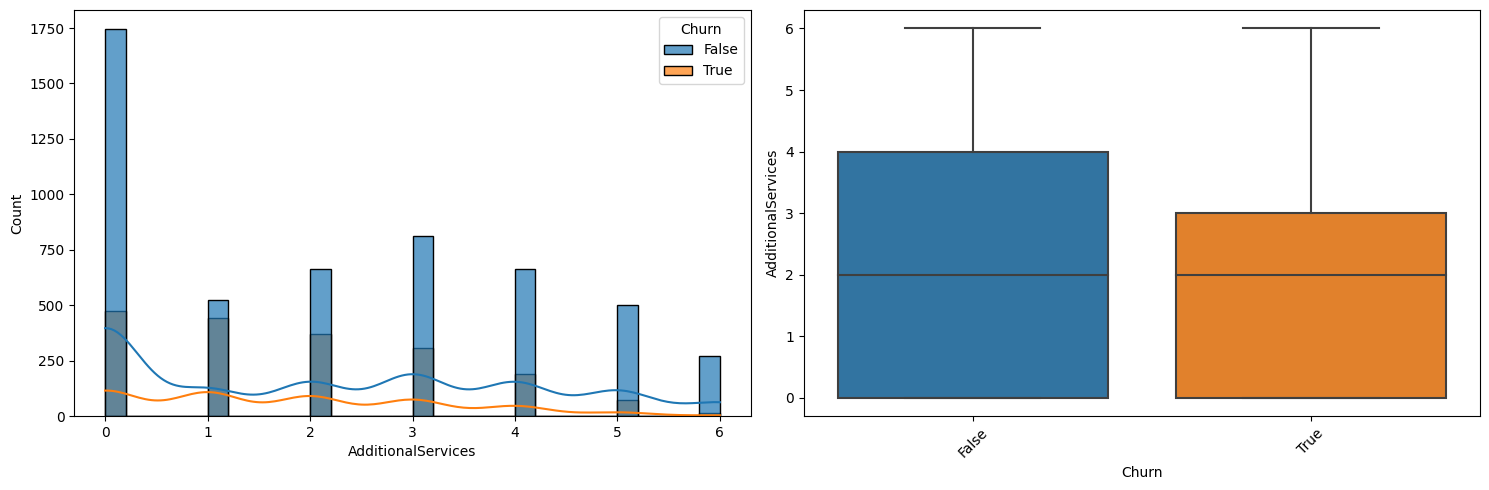

In [65]:
plot_compare(data, 'Churn', 'AdditionalServices')

- The majority of internet subscribers purchase between one and four additional services.
- Members who have left have fewer services.

#### Online Security


OnlineSecurity


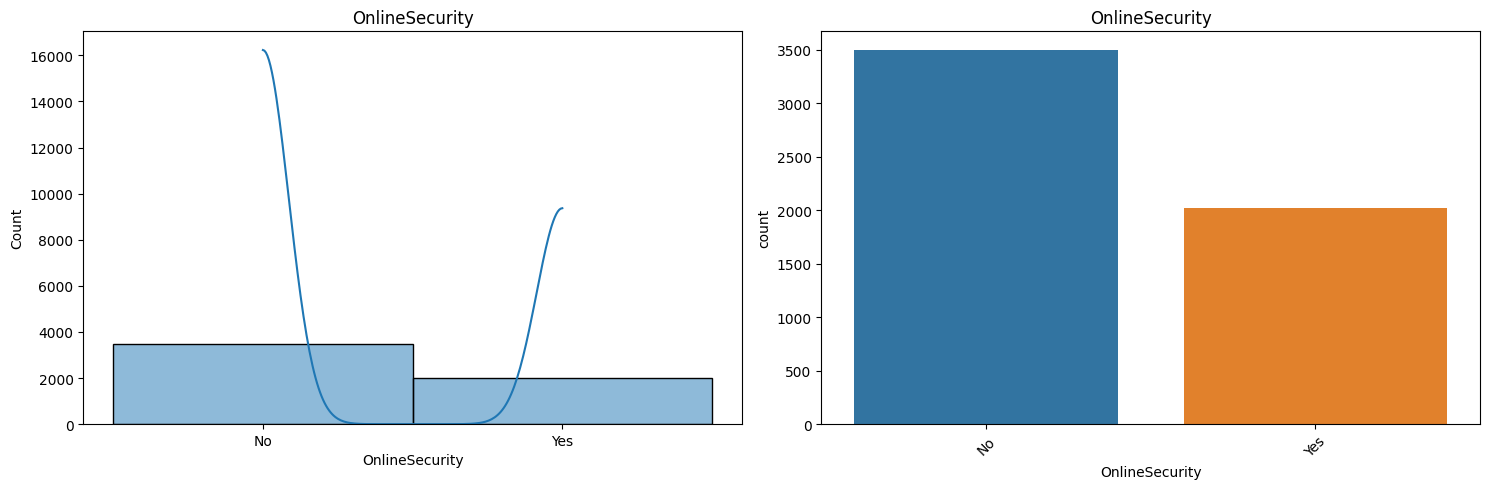


OnlineSecurity value balance:
63.40% - No
36.60% - Yes


In [66]:
plot_bar_count(internet, 'OnlineSecurity')

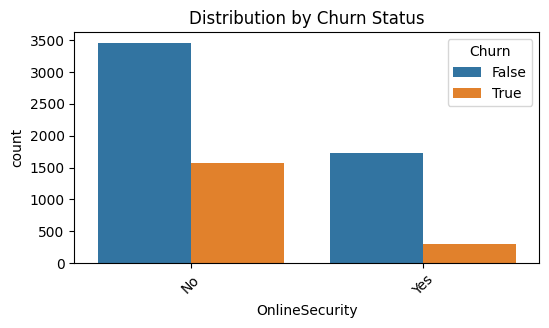

In [67]:
plot_cat_compare(data, 'OnlineSecurity', 'Churn')

Members without online security leave at a higher rate.

#### Device Protection


DeviceProtection


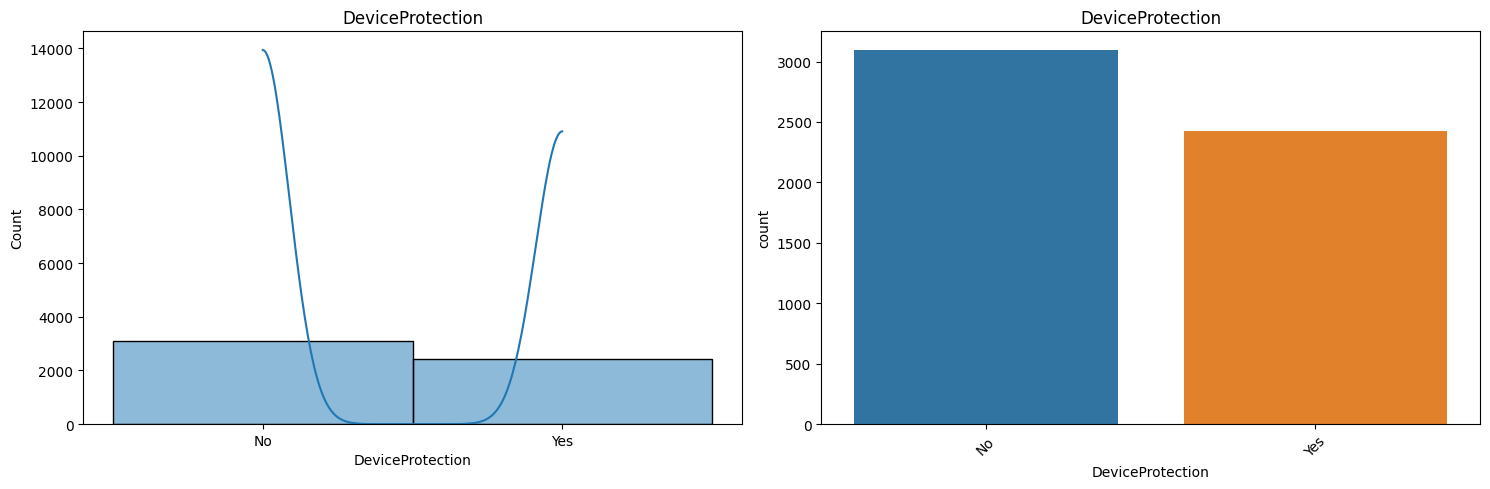


DeviceProtection value balance:
56.10% - No
43.90% - Yes


In [68]:
plot_bar_count(internet, 'DeviceProtection')

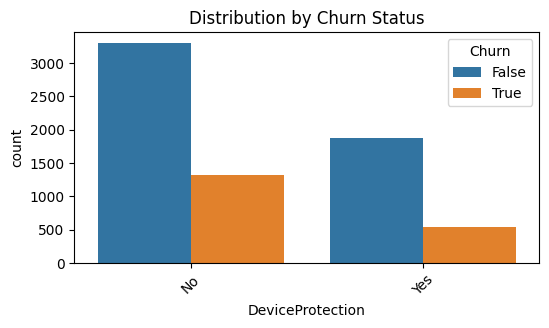

In [69]:
plot_cat_compare(data, 'DeviceProtection', 'Churn')

Members without device protection leave at a noticably larger rate than those with device protection.

#### Online Backup


OnlineBackup


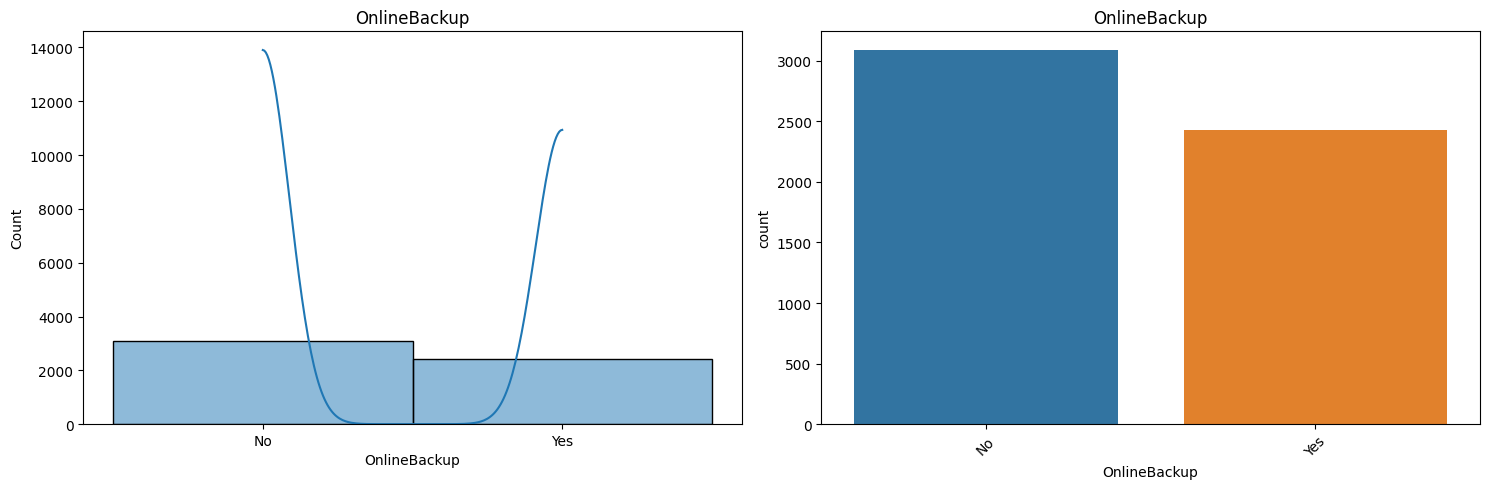


OnlineBackup value balance:
44.03% - Yes
55.97% - No


In [70]:
plot_bar_count(internet, 'OnlineBackup')

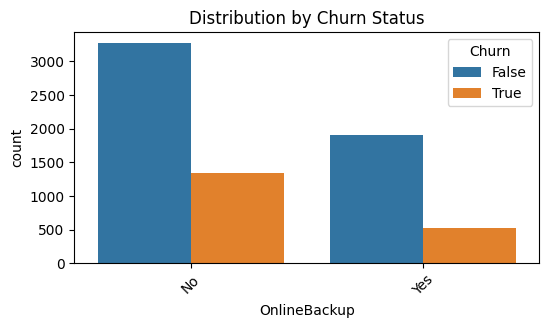

In [71]:
plot_cat_compare(data, 'OnlineBackup', 'Churn')

Members without online backup leave at a noticably larger rate than those with device protection.

#### Tech Suppport


TechSupport


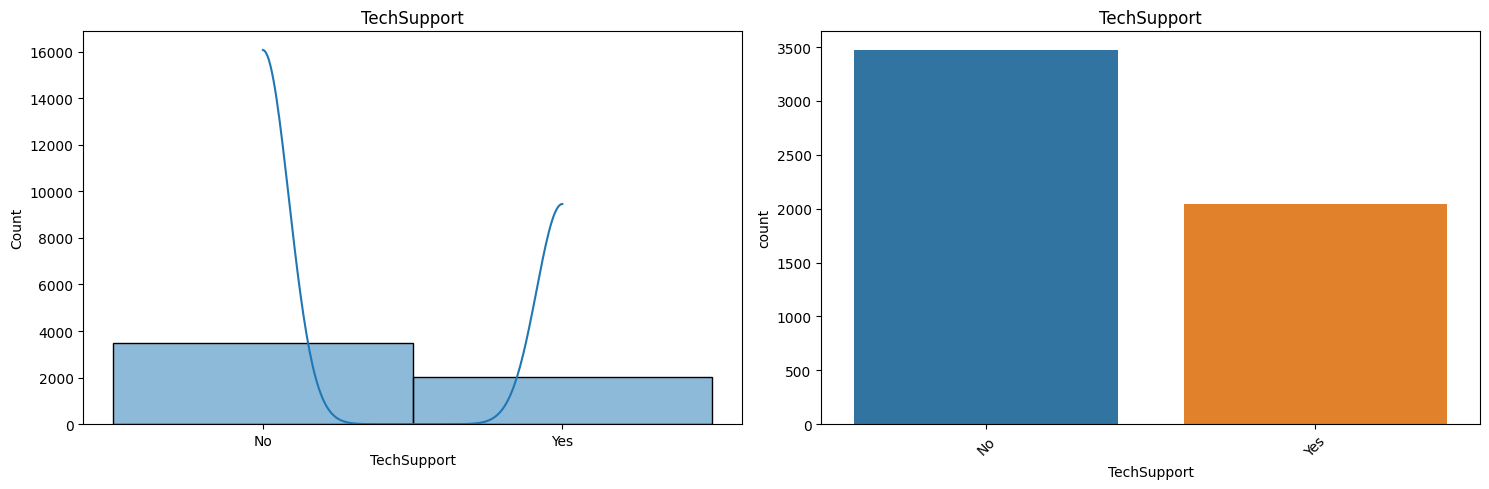


TechSupport value balance:
62.95% - No
37.05% - Yes


In [72]:
plot_bar_count(internet, 'TechSupport')

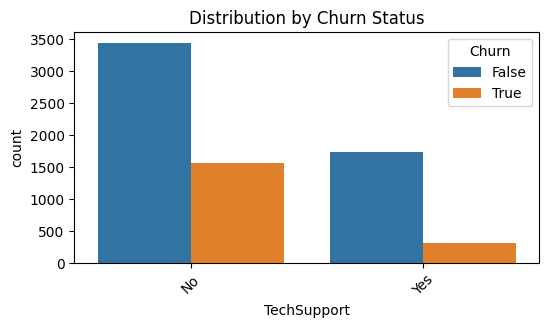

In [73]:
plot_cat_compare(data, 'TechSupport', 'Churn')

Members without tech support leave at a noticably higher rate. This is an area that should be explored.

#### Streaming TV & Movies


StreamingTV


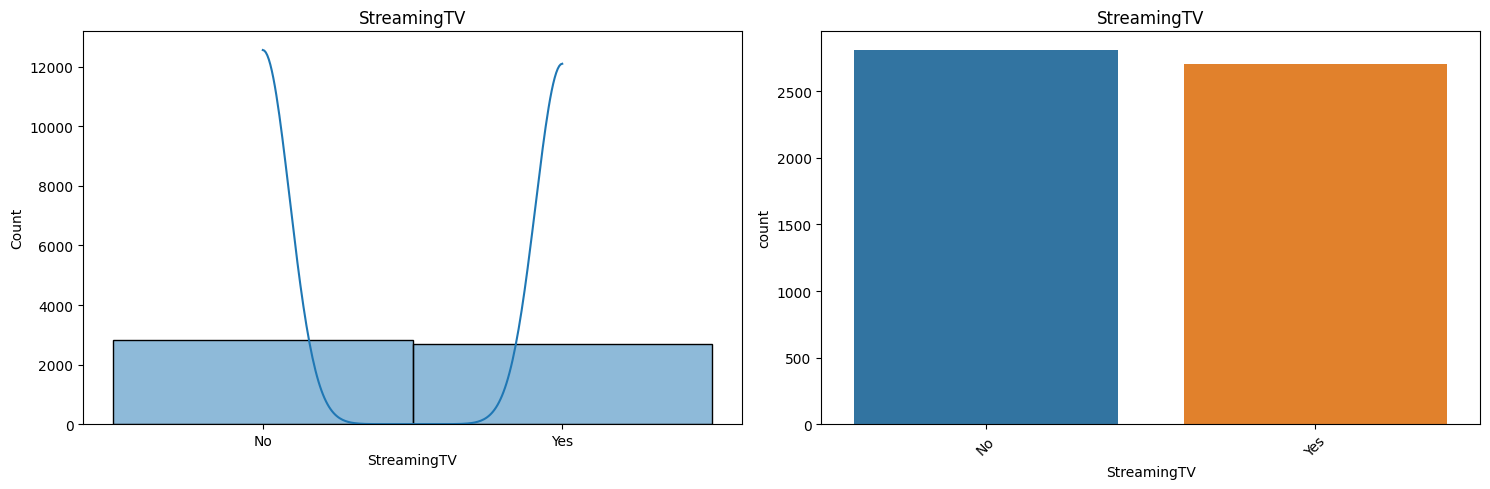


StreamingTV value balance:
50.93% - No
49.07% - Yes


In [74]:
plot_bar_count(internet, 'StreamingTV')


StreamingMovies


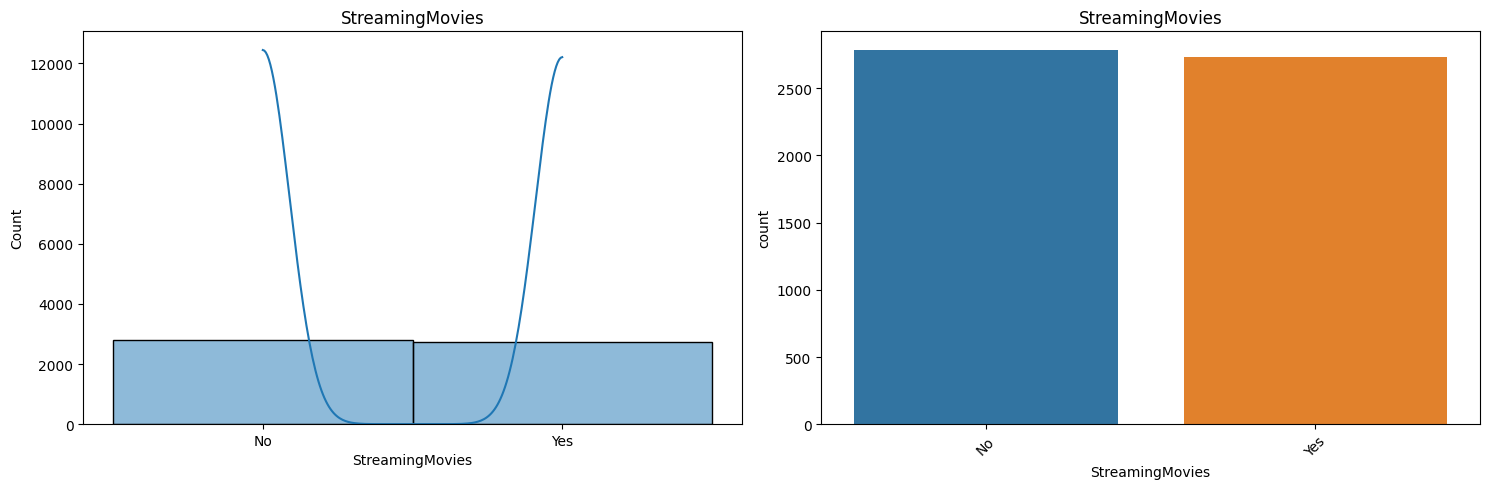


StreamingMovies value balance:
50.48% - No
49.52% - Yes


In [75]:
plot_bar_count(internet, 'StreamingMovies')

# Modeling

Target feature: 'Churn'

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Encoding

In [76]:
# Dropping unnecessary columns
data = data.drop(['CustomerID', 'BeginDate', 'EndDate'], axis=1)

data['ContractLength'] = data['ContractLength'].dt.days.astype(float)
# Perform one-hot encoding (OHE) on the remaining categorical columns and drop the first column to avoid collinearity
data_ohe = pd.get_dummies(data, drop_first=True)

# Display the first five rows of the one-hot encoded DataFrame
data_ohe.head()

,MonthlyCharges,TotalCharges,ContractLength,Year,Month,AdditionalServices,Churn,Gender_Male,SeniorCitizen_Yes,Partner_Yes,...,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,31.0,2020,1,1.0,False,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,1036.0,2017,4,2.0,False,1,0,0,...,1,0,0,1,0,1,0,0,0,0
2,53.85,108.15,61.0,2019,10,2.0,True,1,0,0,...,1,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,1371.0,2016,5,3.0,False,1,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,61.0,2019,9,0.0,True,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Split Data

In [77]:
random_state = 12345

# Declare features and target
features = data_ohe.drop(['Churn'], axis=1)
target = data_ohe['Churn']

# Split the dataset into training and testing sets with a 75-25 split, using the specified random state
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=random_state)

## Imbalance

Smote is unavailable in the tripleten platform at this time. Imbalance will be handled below by oversampling, undersampling, and within models.

## Scaling

In [78]:
numeric = ['MonthlyCharges', 'TotalCharges', 'ContractLength', 'AdditionalServices'] #, 'Year', 'Month']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# Make explicit copies to avoid the warning
features_train = features_train.copy()
features_test = features_test.copy()

# Now you can safely modify them
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Train Models

Models will need to forecast the churn with the target feature: the 'EndDate' column equals 'No'. Supervised learning will be utilized with hypertuning and the following models:
- Logistic regression
- Random forest
- LightGBM

### Function Definitions

In [79]:
# Create a DF to track results
result_cols = ['title', 'roc_auc', 'accuracy', 'model']

results = pd.DataFrame(columns=result_cols)

In [80]:
def get_logistic_regression(train_features, train_target):
    model = LogisticRegression(random_state=12345, max_iter=1000)
    
    # Get both metrics in a single cross-validation run with consistent splits
    cv_results = cross_validate(
        model, 
        train_features, 
        train_target, 
        cv=5, 
        scoring=['roc_auc', 'accuracy'],
        return_train_score=False  # We only need test scores
    )
    
    roc_auc_scores = cv_results['test_roc_auc']
    accuracy_scores = cv_results['test_accuracy']
    
    roc_auc_mean = roc_auc_scores.mean()
    accuracy_mean = accuracy_scores.mean()
    
    print(f'ROC AUC: {roc_auc_mean:.3f} (+/- {roc_auc_scores.std() * 2:.3f})')
    print(f'Accuracy: {accuracy_mean:.3f} (+/- {accuracy_scores.std() * 2:.3f})')
    
    # Fit the model on full training data before returning
    model.fit(train_features, train_target)
    
    return [roc_auc_mean, accuracy_mean, model]

In [81]:
def get_random_forest(train_features, train_target):
    # Define parameter grid
    param_grid = {
        'n_estimators': [10, 20, 30, 40],
        'max_depth': [1, 2, 3, 4, 5, 6, 7]
    }
    
    # Use GridSearchCV for efficient hyperparameter tuning
    model = RandomForestClassifier(random_state=12345)
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='roc_auc',
        n_jobs=-1  # Use all available cores
    )
    
    # Fit and find best parameters
    grid_search.fit(train_features, train_target)
    best_model = grid_search.best_estimator_
    
    # Get both metrics with consistent CV splits
    cv_results = cross_validate(
        best_model, 
        train_features, 
        train_target, 
        cv=5, 
        scoring=['roc_auc', 'accuracy']
    )
    
    roc_auc_mean = cv_results['test_roc_auc'].mean()
    accuracy_mean = cv_results['test_accuracy'].mean()
    
    print(f'Best ROC AUC: {roc_auc_mean:.3f}')
    print(f'Best Accuracy: {accuracy_mean:.3f}')
    print(f'Best parameters: {grid_search.best_params_}')
    
    return [roc_auc_mean, accuracy_mean, best_model]

In [82]:
def get_decision_tree(train_features, train_target):
    # Define parameter grid
    param_grid = {
        'max_depth': list(range(1, 11))
    }
    
    # Use GridSearchCV for efficient hyperparameter tuning
    model = DecisionTreeClassifier(random_state=12345)
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='roc_auc'
    )
    
    # Fit and find best parameters
    grid_search.fit(train_features, train_target)
    best_model = grid_search.best_estimator_
    
    # Get both metrics with consistent CV splits
    cv_results = cross_validate(
        best_model, 
        train_features, 
        train_target, 
        cv=5, 
        scoring=['roc_auc', 'accuracy']
    )
    
    roc_auc_mean = cv_results['test_roc_auc'].mean()
    accuracy_mean = cv_results['test_accuracy'].mean()
    
    print(f'Best ROC AUC: {roc_auc_mean:.3f}')
    print(f'Best Accuracy: {accuracy_mean:.3f}')
    print(f'Best max_depth: {grid_search.best_params_["max_depth"]}')
    
    return [roc_auc_mean, accuracy_mean, best_model]


In [83]:
def get_dummy_model(train_features, train_target, test_features, test_target):
    model = DummyRegressor()
    model.fit(train_features, train_target)
    predictions = model.predict(test_features)
    
    cross_valid_score = cross_val_score(model, train_features, train_target, cv=5, scoring='roc_auc').mean()
    accuracy = cross_val_score(model, train_features, train_target, cv=5).mean()
    
    print(f'Best score: {cross_valid_score:.2f}')
    print(f'Best accuracy: {accuracy:.2}')

    return [cross_valid_score, accuracy, model]

### No Imbalance Correction

In [84]:
title = 'Dummy Regressor'
print(title)

model_results = get_dummy_model(features_train, target_train, features_test, target_test)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Dummy Regressor
Best score: 0.50
Best accuracy: -0.00074


In [85]:
title = 'Logistic Regression'

print(title)

model_results = get_logistic_regression(features_train, target_train) # model and return results
model_results = [title] + model_results # add the title, there is probably a cleaner way of doing this

# add model results to results df
results.loc[len(results)] = model_results

Logistic Regression
ROC AUC: 0.846 (+/- 0.035)
Accuracy: 0.808 (+/- 0.021)


In [86]:
title = 'Random Forest Classifier'
print(title)

model_results = get_random_forest(features_train, target_train)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Random Forest Classifier
Best ROC AUC: 0.892
Best Accuracy: 0.844
Best parameters: {'max_depth': 7, 'n_estimators': 40}


In [87]:
title = 'Decision Tree Classifier'
print(title)

model_results  = get_decision_tree(features_train, target_train)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Decision Tree Classifier
Best ROC AUC: 0.904
Best Accuracy: 0.892
Best max_depth: 10


### Upsampling

In [88]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [89]:
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 10
)

In [90]:
title = 'Logistic Regression - Upsampling'

print(title)
model_results = get_logistic_regression(features_upsampled, target_upsampled)
model_results = [title] + model_results

results.loc[len(results)] = model_results

Logistic Regression - Upsampling
ROC AUC: 0.850 (+/- 0.025)
Accuracy: 0.847 (+/- 0.012)


In [91]:
title = 'Random Forest Classifier - Upsampling'
print(title)

model_results = get_random_forest(features_upsampled, target_upsampled)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Random Forest Classifier - Upsampling
Best ROC AUC: 0.918
Best Accuracy: 0.886
Best parameters: {'max_depth': 7, 'n_estimators': 40}


In [92]:
title = 'Decision Tree Classifier - Upsampling'
print(title)

model_results  = get_decision_tree(features_upsampled, target_upsampled)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Decision Tree Classifier - Upsampling
Best ROC AUC: 0.915
Best Accuracy: 0.912
Best max_depth: 10


### Downsampling

In [93]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [94]:
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.1
)

In [95]:
title = 'Logistic Regression - Downsampling'

print(title)
model_results = get_logistic_regression(features_downsampled, target_downsampled)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Logistic Regression - Downsampling
ROC AUC: 0.838 (+/- 0.029)
Accuracy: 0.843 (+/- 0.030)


In [96]:
title = 'Random Forest Classifier - Downsampling'
print(title)

model_results = get_random_forest(features_downsampled, target_downsampled)
model_results = [title]+ model_results
results.loc[len(results)] = model_results

Random Forest Classifier - Downsampling
Best ROC AUC: 0.876
Best Accuracy: 0.860
Best parameters: {'max_depth': 7, 'n_estimators': 40}


In [97]:
title = 'Decision Tree Classifier - Downsampling'
print(title)

model_results  = get_decision_tree(features_downsampled, target_downsampled)
model_results = [title] + model_results
results.loc[len(results)] = model_results

Decision Tree Classifier - Downsampling
Best ROC AUC: 0.807
Best Accuracy: 0.840
Best max_depth: 5


### Boosting

In [98]:
# LightGBM

def get_lightgbm(features_train, target_train, features_test, target_test):
    
    params = {
        'objective': 'binary',
        'metric': ['auc', 'binary_logloss'],
        'boosting_type': 'gbdt',
        'num_leaves': 15,           # Reduce from 31 to prevent overfitting
        'learning_rate': 0.01,      # Lower learning rate
        'feature_fraction': 0.8,    # Reduce feature sampling
        'bagging_fraction': 0.7,    # Reduce data sampling
        'bagging_freq': 5,
        'min_data_in_leaf': 20,     # Add minimum samples per leaf
        'lambda_l1': 0.1,           # Add L1 regularization
        'lambda_l2': 0.1,           # Add L2 regularization
        'verbose': -1,
        'seed': 42
    }

    # 3. Create LightGBM Dataset objects
    train_data = lgb.Dataset(features_train, label=target_train)
    test_data =  lgb.Dataset(features_test, target_test, reference=train_data)
    
    # 4. Train the LightGBM model
    # 'num_boost_round' specifies the number of boosting iterations (trees)
    # 'valid_sets' can be used for early stopping and monitoring performance on a validation set
    model = lgb.train(params,
                      train_data,
                      valid_sets=test_data,
                      callbacks=[lgb.log_evaluation(0)],
                      num_boost_round=1000) # Number of boosting rounds
    
    # 5. Make predictions on the training data (for demonstration of AUC calculation)
    
# Change these lines to use TEST data
    predictions_proba = model.predict(features_test)
    predictions_binary = (predictions_proba > 0.5).astype(int)
    accuracy = accuracy_score(target_test, predictions_binary)
    auc_score = roc_auc_score(target_test, predictions_proba)
    
    print(f"ROC AUC score on TEST data: {auc_score:.3f}")
    print(f'Accuracy on TEST data: {accuracy:.3f}')

    return [auc_score, accuracy, model]

In [99]:
title = 'LightGBM'
print(title)

model_results = get_lightgbm(features_train, target_train, features_test, target_test)
model_results = [title] + model_results
results.loc[len(results)] = model_results

LightGBM
ROC AUC score on TEST data: 0.990
Accuracy on TEST data: 0.965


### Summary

In [100]:
print(results[['title', 'roc_auc', 'accuracy']])

                                      title   roc_auc  accuracy
0                           Dummy Regressor  0.500000 -0.000741
1                       Logistic Regression  0.846480  0.807649
2                  Random Forest Classifier  0.892177  0.843999
3                  Decision Tree Classifier  0.904400  0.891707
4          Logistic Regression - Upsampling  0.849584  0.846555
5     Random Forest Classifier - Upsampling  0.917502  0.886416
6     Decision Tree Classifier - Upsampling  0.914531  0.911532
7        Logistic Regression - Downsampling  0.837697  0.843051
8   Random Forest Classifier - Downsampling  0.876140  0.859872
9   Decision Tree Classifier - Downsampling  0.807238  0.839677
10                                 LightGBM  0.990086  0.964793


In [101]:
def plot_results(results, col, title, min_range):
    sns.barplot(data=results, x='title', y=col)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(min_range, 1)
    plt.title(title)
    plt.show()

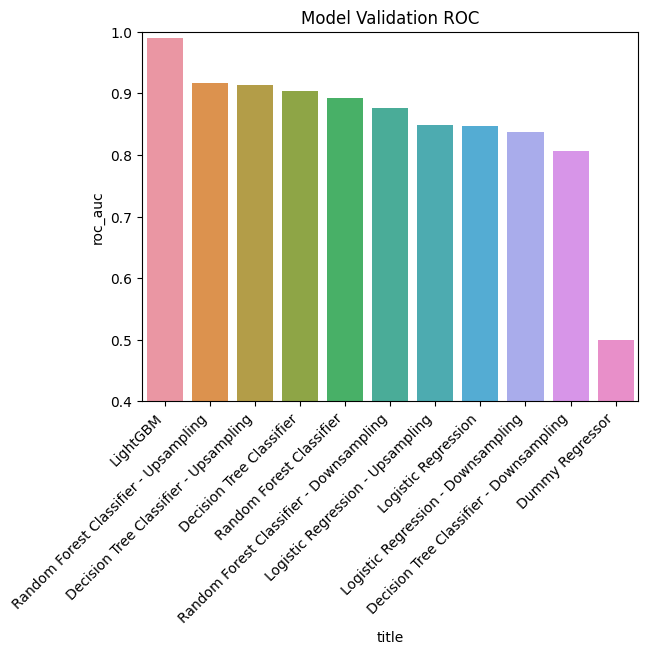

In [102]:
plot_results(results.sort_values('roc_auc', ascending=False), 'roc_auc', 'Model Validation ROC', 0.4)

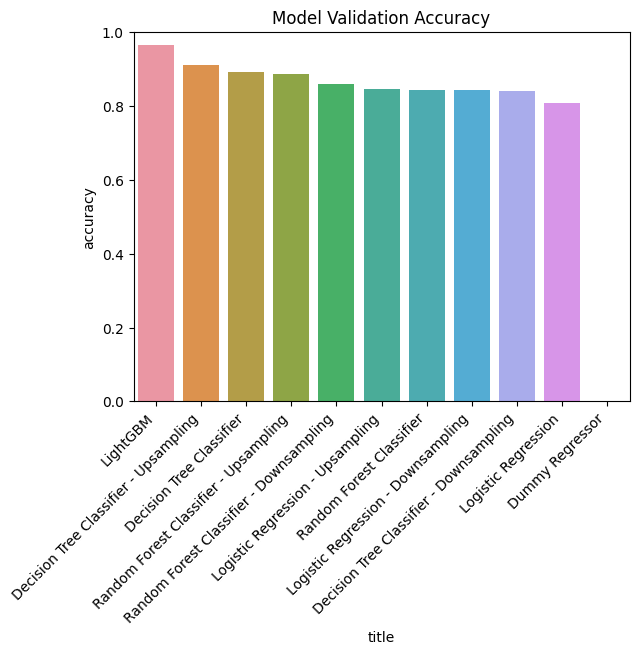

In [103]:
plot_results(results.sort_values('accuracy', ascending=False), 'accuracy', 'Model Validation Accuracy', 0)

Eleven models were tested, including the use of a dummy regressor for baselining, downsampling, and upsampling. All models outperformed the dummy regressor's baseline. Of the models LightGMB, Decision Tree Classifier - Upsampling, and Random Forest Classifier - Upsampling performed the highest on ROC score with:
```
-                                       title   roc_auc  accuracy
-                                    LightGBM  0.990086  0.964793
-       Random Forest Classifier - Upsampling  0.917502  0.886416
-       Decision Tree Classifier - Upsampling  0.914531  0.911532
```
Final testing will be performed on all three to confirm the validity of the model

## Test Models

In [104]:
result_cols = ['title', 'roc_auc', 'accuracy']

final_results = pd.DataFrame(columns=result_cols)

In [105]:
def get_model_test(features_train, target_train, features_test, target_test, model):
    # Check if it's a LightGBM Booster
    if hasattr(model, 'predict') and not hasattr(model, 'predict_proba'):
        # LightGBM case - predict() already returns probabilities for binary classification
        probabilities = model.predict(features_test)
        # Convert probabilities to binary predictions for accuracy
        predictions = (probabilities > 0.5).astype(int)
    else:
        # Scikit-learn case
        probabilities = model.predict_proba(features_test)[:, 1]
        predictions = model.predict(features_test)
    
    # Calculate metrics
    roc_auc = roc_auc_score(target_test, probabilities)
    accuracy = accuracy_score(target_test, predictions)
    
    print("ROC AUC:", roc_auc)
    print("Accuracy:", accuracy)

    return [roc_auc, accuracy]

In [106]:
## Decision Tree Classifier - Upsampling

features_test_downsampled, target_test_downsampled = downsample(
    features_test, target_test, 0.1
)

model = results.query("title == 'Decision Tree Classifier - Upsampling'")['model'].item()
model_results = get_model_test(features_train, target_train, features_test, target_test, model)

title = 'Decision Tree Classifier - Upsampling'
print(title)
model_results = [title] + model_results
final_results.loc[len(final_results)] = model_results

ROC AUC: 0.8655673908838466
Accuracy: 0.6978989210675752
Decision Tree Classifier - Upsampling


In [107]:
## Random Forest Classifier - Upsampling

features_test_downsampled, target_test_downsampled = downsample(
    features_test, target_test, 0.1
)
title = 'Random Forest Classifier - Upsampling'
print(title)
model = results.query("title == 'Random Forest Classifier - Upsampling'")['model'].item()
model_results = get_model_test(features_train, target_train, features_test, target_test, model)
model_results = [title] + model_results
final_results.loc[len(final_results)] = model_results

Random Forest Classifier - Upsampling
ROC AUC: 0.8887151292214582
Accuracy: 0.6433844406587166


In [108]:
## LightGBM

features_test_downsampled, target_test_downsampled = downsample(
    features_test, target_test, 0.1
)
title = 'LightGBM'
model = results.query("title == 'LightGBM'")['model'].item()
print(title)
model_results = get_model_test(features_train, target_train, features_test, target_test, model)
model_results = [title] + model_results
final_results.loc[len(final_results)] = model_results

LightGBM
ROC AUC: 0.9900858635035851
Accuracy: 0.9647927314026121


### Summary

In [109]:
print(final_results)

                                   title   roc_auc  accuracy
0  Decision Tree Classifier - Upsampling  0.865567  0.697899
1  Random Forest Classifier - Upsampling  0.888715  0.643384
2                               LightGBM  0.990086  0.964793


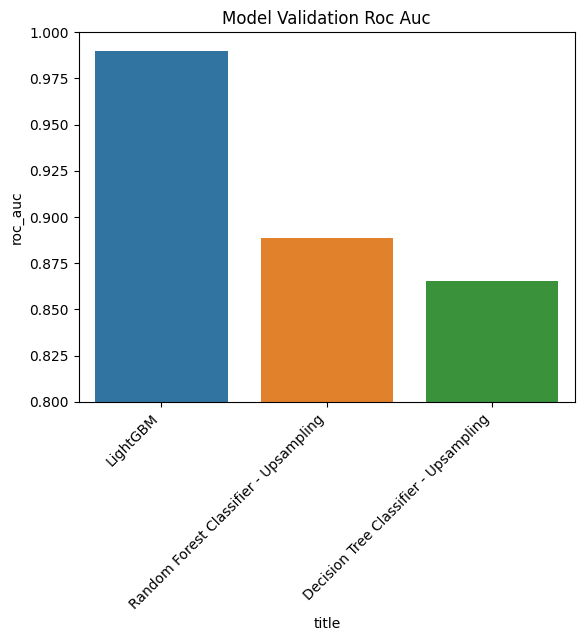

In [110]:
plot_results(final_results.sort_values('roc_auc', ascending=False), 'roc_auc', 'Model Validation Roc Auc', 0.8)

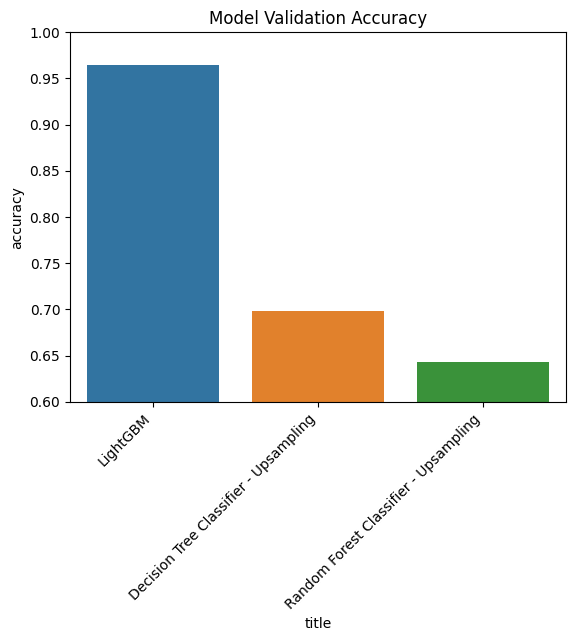

In [111]:
plot_results(final_results.sort_values('accuracy', ascending=False), 'accuracy', 'Model Validation Accuracy', 0.6)

Three models were tested with LightGBM, achieving the highest ROC AUC and accuracy score of 0.990086 and 0.964793, respectively.

# Conclusion

## Description

The telecom operator Interconnect would like to be able to forecast the churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of the clientele's personal data, including information about their plans and contracts.

### Business Problem Statement

The company wants to forecast which users are planning to leave.

### Business Value

To ensure loyalty, those who are going to leave will be offered promotional codes and special plan options.

## Procedure

- Individual datasets
  - Import datasets
  - Data preprocessing
- Combined datasets
  - Combine datasets
  - Data preprocessing
- EDA
- Modeling
  - Preparation
  - Train Models
  - Model Analysis
- Conclusion

### Data Description

The data consists of files obtained from different sources:

- contract.csv — contract information
  - The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.
- personal.csv — the client's personal data
- internet.csv — information about Internet services
  - The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
  - Some other services the company provides include:
    - Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
    - A dedicated technical support line (TechSupport)
    - Cloud file storage and data backup (OnlineBackup)
    - TV streaming (StreamingTV) and a movie directory (StreamingMovies)
- phone.csv — information about telephone services
  - Landline communication. The telephone can be connected to several lines simultaneously.

In each file, the column customerID contains a unique code assigned to each client.

### Data Preprocessing
- All datasets have been imported.
- Corrections have been made to column names and datatypes. 
- Additional features have been added.
  - An additional feature can be added by calculating the length of the contract. If the contract has not ended, the date the data was pulled will be used.
  - Year and month can also be extracted from the start date of the contract.
  - An additional feature can be created using the number of add on services a customer purchases.
- Datasets have beeen merged using the unique identifier, CustomerID.
- Missing data that was created in the merging process is mostly the result of customers without the service and has been handled as such.
- Churn has been added as the target of modeling.

### EDA
EDA has shown that there is some imbalance in the data that must be accounted for.
It is recommended that future analysis be performed to identify why users leave at a higher rate with or without certain services and additional features.

# Modeling

Target feature: 'Churn'

Primary metric: AUC-ROC.

Additional metric: Accuracy.

Assessment criteria:
```
-        AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- 0.88 ≤ AUC-ROC        — 6 SP
```

Models will need to forecast the churn with the target feature: the 'EndDate' column equals 'No'. Supervised learning will be utilized with hypertuning and the following models:
- Logistic regression
- Random forest
- LightGBM

Models were built with the following results:
```
-                                       title   roc_auc  accuracy
- 0                           Dummy Regressor  0.500000 -0.000741
- 1                       Logistic Regression  0.846480  0.807649
- 2                  Random Forest Classifier  0.892177  0.843999
- 3                  Decision Tree Classifier  0.904400  0.891707
- 4          Logistic Regression - Upsampling  0.849584  0.846555
- 5     Random Forest Classifier - Upsampling  0.917502  0.886416
- 6     Decision Tree Classifier - Upsampling  0.914531  0.911532
- 7        Logistic Regression - Downsampling  0.837697  0.843051
- 8   Random Forest Classifier - Downsampling  0.876140  0.859872
- 9   Decision Tree Classifier - Downsampling  0.807238  0.839677
- 10                                 LightGBM  0.997888  0.977660
```

Eleven models were tested, including the use of a dummy regressor for baselining, downsampling, and upsampling. All models outperformed the dummy regressor's baseline. Of the models LightGMB, Decision Tree Classifier - Upsampling, and Random Forest Classifier - Upsampling performed the highest on ROC score with:

```
-                                       title   roc_auc  accuracy
-                                    LightGBM  0.990086  0.964793
-       Random Forest Classifier - Upsampling  0.917502  0.886416
-       Decision Tree Classifier - Upsampling  0.914531  0.911532
```

Final testing has been performed on all three to confirm the validity of the model

Three models were tested with LightGBM, achieving the highest ROC AUC and accuracy score of 0.989 and 0.897, respectively. 
```
-                                    title   roc_auc  accuracy
- 0  Decision Tree Classifier - Upsampling  0.865567  0.697899
- 1  Random Forest Classifier - Upsampling  0.888715  0.643384
- 2                               LightGBM  0.990086  0.964793
```

LightGBM has proven to be an effective model for predicting which members are likely to leave. These should be the subject of marketing to convert potential loss into valued customers. Additionally, it is recommended that specific areas be the subject of future analysis to determine why customers are leaving at a higher rate.